### Viz of different classification datasets using Force Directed Graph on DistanceMatrix
* Concentric n-dimen spheres

In [6]:
import numpy as np

In [7]:
# Generating n-dimen concentric spheres data
def generateNDSpheres(N=3, C=3, M_C=5000):
    # N is number of dimensions
    # C is number of classes
    # M_C is number of examples per class
    M = C*M_C
    X = np.zeros((M,N))
    y = np.zeros(M)
    for c in range(C):
        R = 100*(c+1)
        aggSum = np.zeros(M_C)
        for n in range(N):
            X2 = None
            if n == N-1:
                X2 = (R*R - aggSum)
            else:
                X2 = np.multiply((R*R-aggSum), np.random.rand(M_C))
            aggSum+=X2
            X[c*M_C:(c+1)*M_C,n] = np.multiply(2*np.random.randint(2, size=M_C)-1, np.sqrt(X2))
        y[c*M_C:(c+1)*M_C] = c
    return X,y
C=2
M_C=300
SX, Sy = generateNDSpheres(N=3, C=C, M_C=M_C)

In [8]:
print(SX[:2])
print(Sy[:2])

[[ 51.85627099 -56.39716512  64.26730837]
 [-74.09039619 -63.99321943  20.38335248]]
[ 0.  0.]


<IPython.core.display.Javascript object>


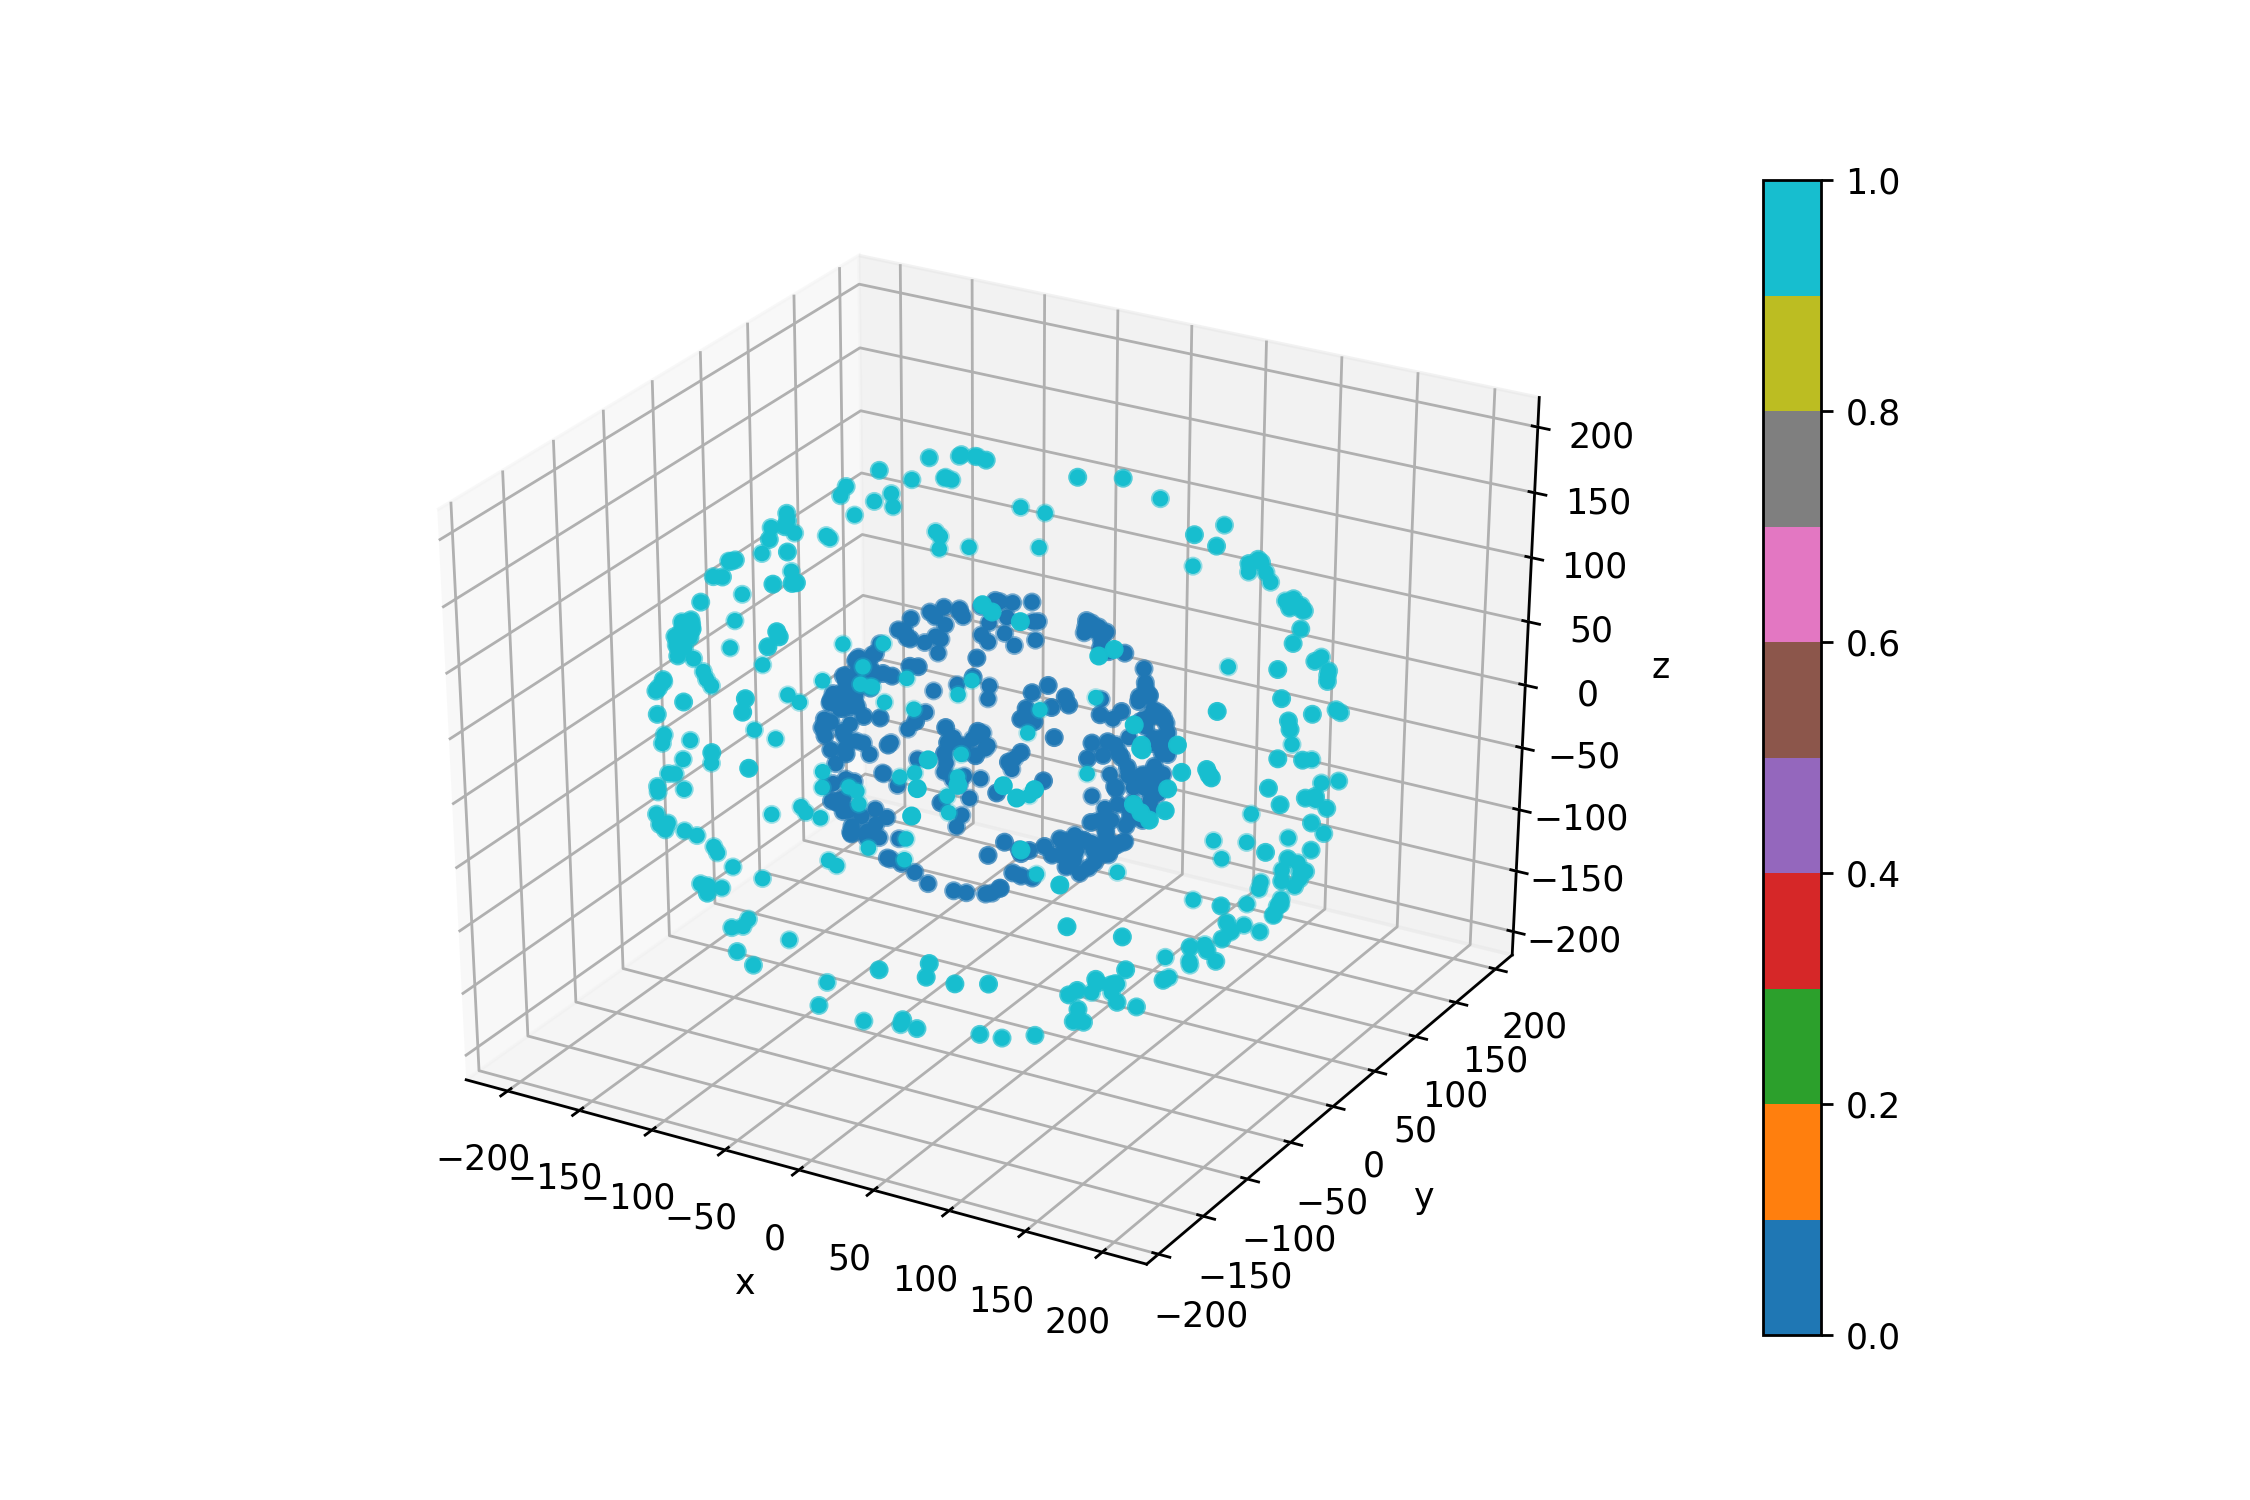

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
def plot3D(X,y):
    %matplotlib notebook
    plt.ion()

    fig = plt.figure(figsize=(9,6))
    chart3d = fig.add_subplot(111, projection='3d')
    c3d = chart3d.scatter(X[:,0], X[:,1], X[:,2], c=y[:], cmap=cm.tab10)
    chart3d.set_xlabel('x')
    chart3d.set_ylabel('y')
    chart3d.set_zlabel('z')
    fig.colorbar(c3d)
    plt.show()
    
plot3D(SX, Sy)

In [78]:
def distanceMatrix(X,Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return dm

In [77]:
import networkx as nx
from random import shuffle

colors = ["blue", "red", "green", "yellow", "brown", "pink", "orange", "gray", "cyan", "greenyellow"]

def genGraph(dm, y, sample_edges=100000):
    N, = y.shape
    G=nx.Graph()
    for i in range(N):
        G.add_node(i, {'color':colors[int(y[i])], 'cluster':int(y[i])})
    
    weighted_edges = []
    #max_dist = np.max(np.asarray(dm))
    for i in range(N):
        for j in range(i+1,N):
            weighted_edges.append((i,j, 1/(dm[i,j]+1e-8)))
    shuffle(weighted_edges)
    if sample_edges is None:
        G.add_weighted_edges_from(weighted_edges)
    else:
        G.add_weighted_edges_from(weighted_edges[0:sample_edges])
    return G

def genKNNGraph(dm, y, k=10, farther=True):
    N,M = dm.shape
    G=nx.Graph()
    for i in range(N):
        G.add_node(i, {'color':colors[int(y[i])], 'cluster':int(y[i])})
    dm_arr = np.asarray(dm)
    sorted_indices = np.argsort(dm_arr, axis=1)
    weighted_edges = []
    for i in range(N):
        for j in range(k+1):
            index = int(sorted_indices[i][j])
            if i!=index:
                if i < index:
                    weighted_edges.append((i,index, 1/(dm[i,index]+1e-8)))
                else:
                    weighted_edges.append((index,i, 1/(dm[i,index]+1e-8)))
        if farther:
            step = int((M-k-1)/k)
            for j in range(k+1,M,step):
                index = int(sorted_indices[i][j])
                if i!=index:
                    if i < index:
                        weighted_edges.append((i,index, 1/(dm[i,index]+1e-8)))
                    else:
                        weighted_edges.append((index,i, 1/(dm[i,index]+1e-8)))
            
    final_weighted_edges = list(set(weighted_edges))
    print(len(final_weighted_edges))
    G.add_weighted_edges_from(final_weighted_edges)
    return G
    
def plotFDGraph(G, pos, y):
    %matplotlib notebook
    plt.ion()
    N, = y.shape
    for n in range(N):
        nx.draw_networkx_nodes(G,pos, with_labels=False, nodelist=[n], node_size=10,
                               node_color=colors[int(y[n])])
    plt.axis('off')
    plt.show()

In [17]:
from networkx.readwrite import json_graph
import json
def graphJsonDump(G, filename='graph.json'):
    data = json_graph.node_link_data(G)
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [80]:
def dmSpringGraph(X,y, iterations=50, dim=2, plot=True, sample_edges=100000):
    dm = distanceMatrix(X, X)
    G = genGraph(dm, y, sample_edges=sample_edges)
    if plot:
        pos = nx.spring_layout(G, dim=dim, iterations=iterations)
        plotFDGraph(G, pos, y)
    return G

def dmSpringKNNGraph(X,y, iterations=50, dim=2, plot=True, k=10, farther=True):
    dm = distanceMatrix(X, X)
    G = genKNNGraph(dm, y, k=k, farther=farther)
    if plot:
        pos = nx.spring_layout(G, dim=dim, iterations=iterations)
        plotFDGraph(G, pos, y)
    return G

<IPython.core.display.Javascript object>


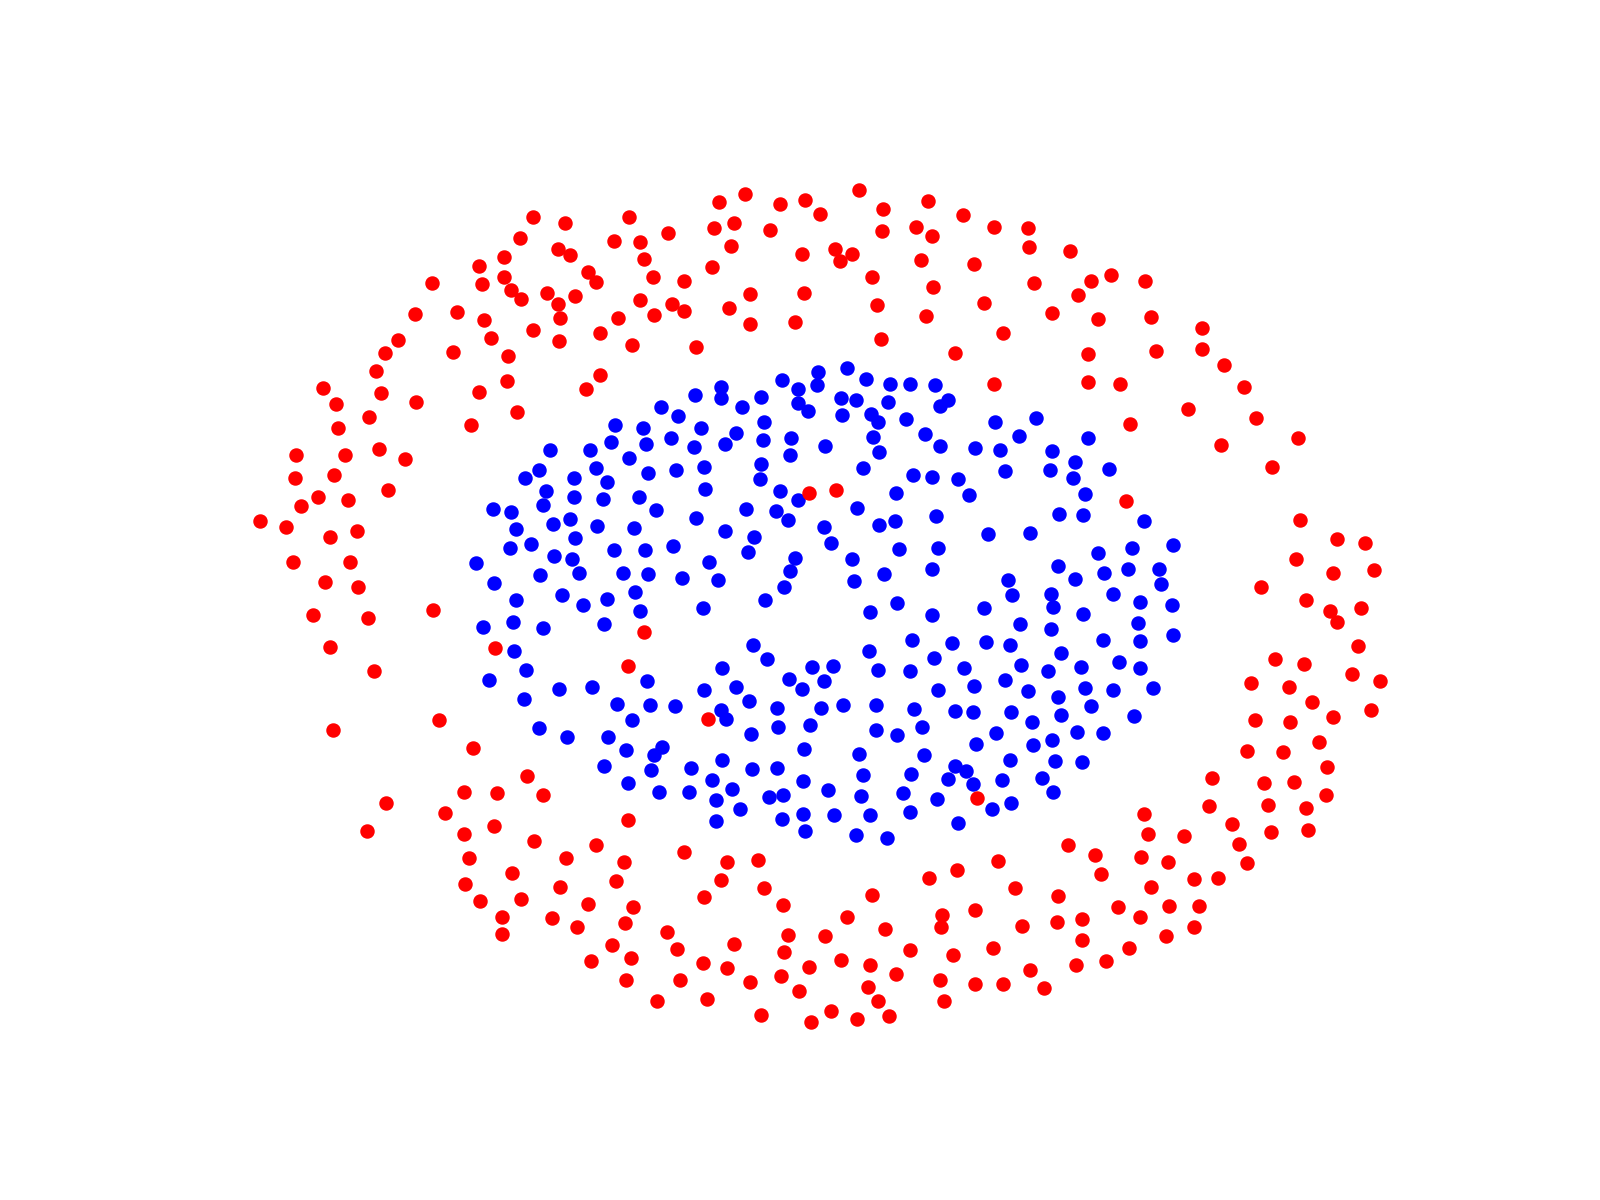

In [72]:
dmSpringGraph(SX,Sy, iterations=100)

49888


<IPython.core.display.Javascript object>


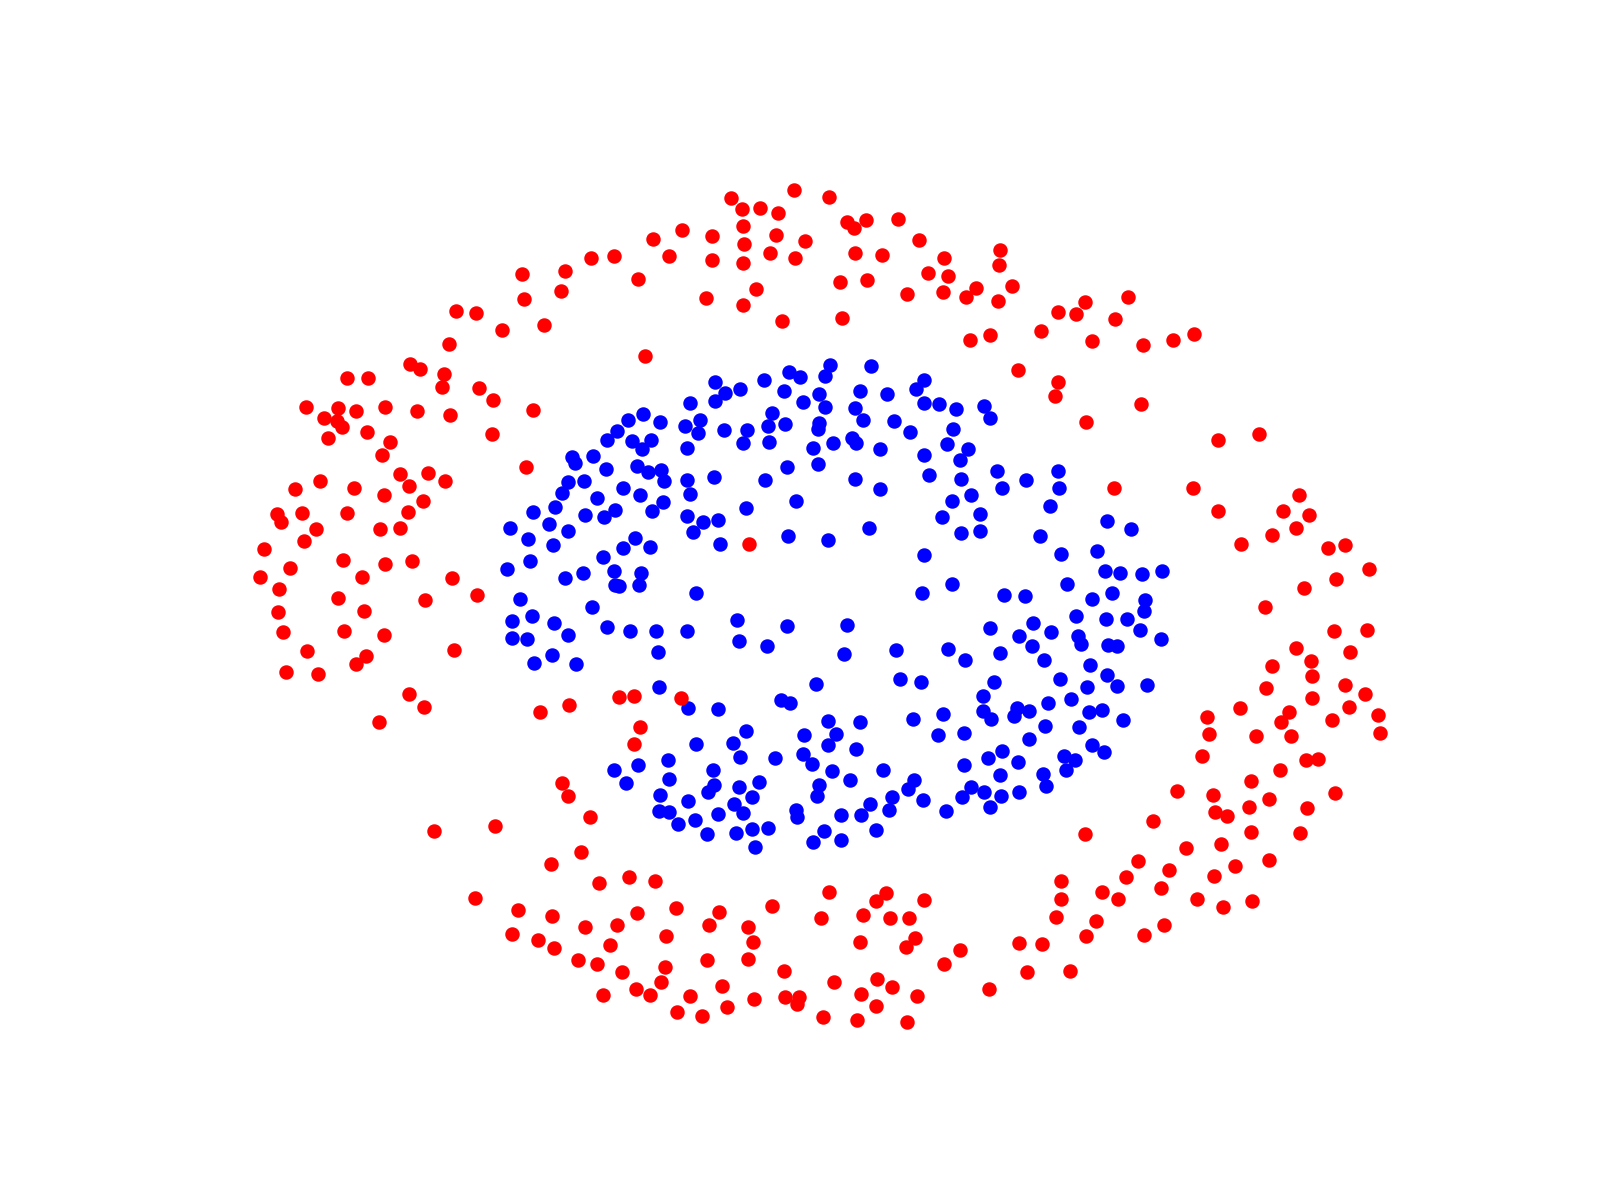

In [73]:
dmSpringKNNGraph(SX, Sy, iterations=100, k=50)

In [20]:
graphJsonDump(dmSpringGraph(SX,Sy,plot=False), "viz-d3/graphs/SGraph.json")

In [21]:
from sklearn.datasets import make_blobs
BX, By = make_blobs(n_samples=900, centers=3, n_features=4, random_state=0)
print(BX.shape)
print(By.shape)

(900, 4)
(900,)


<IPython.core.display.Javascript object>


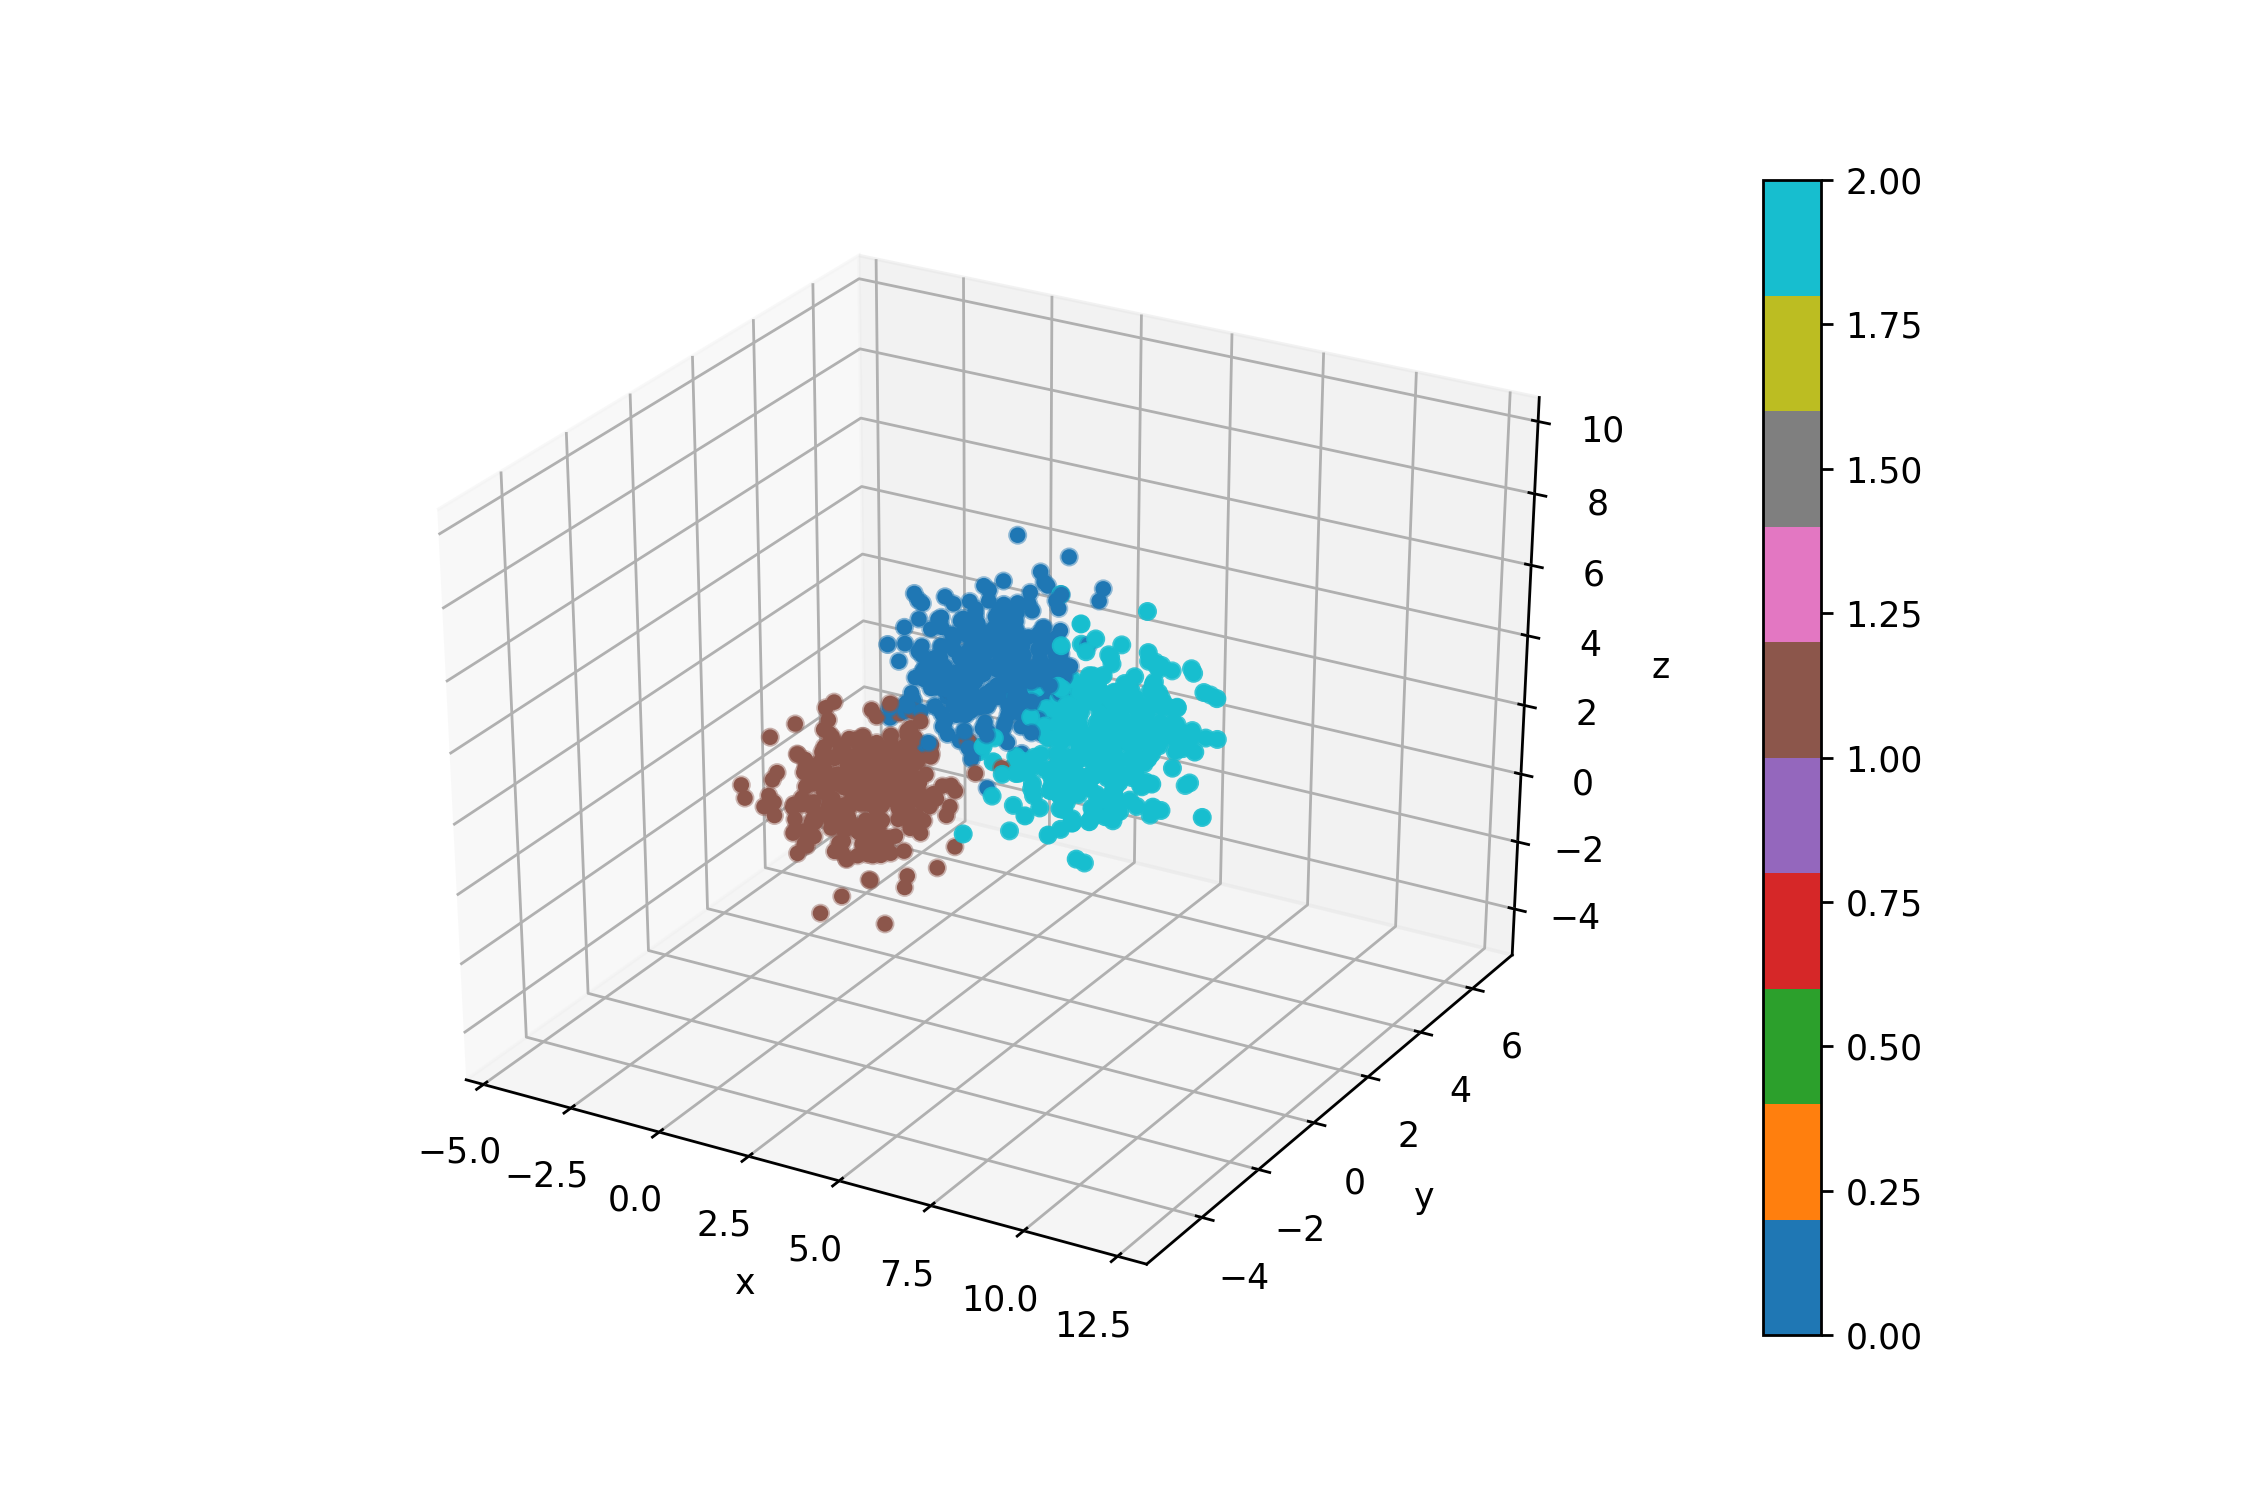

In [22]:
plot3D(BX, By)

<IPython.core.display.Javascript object>


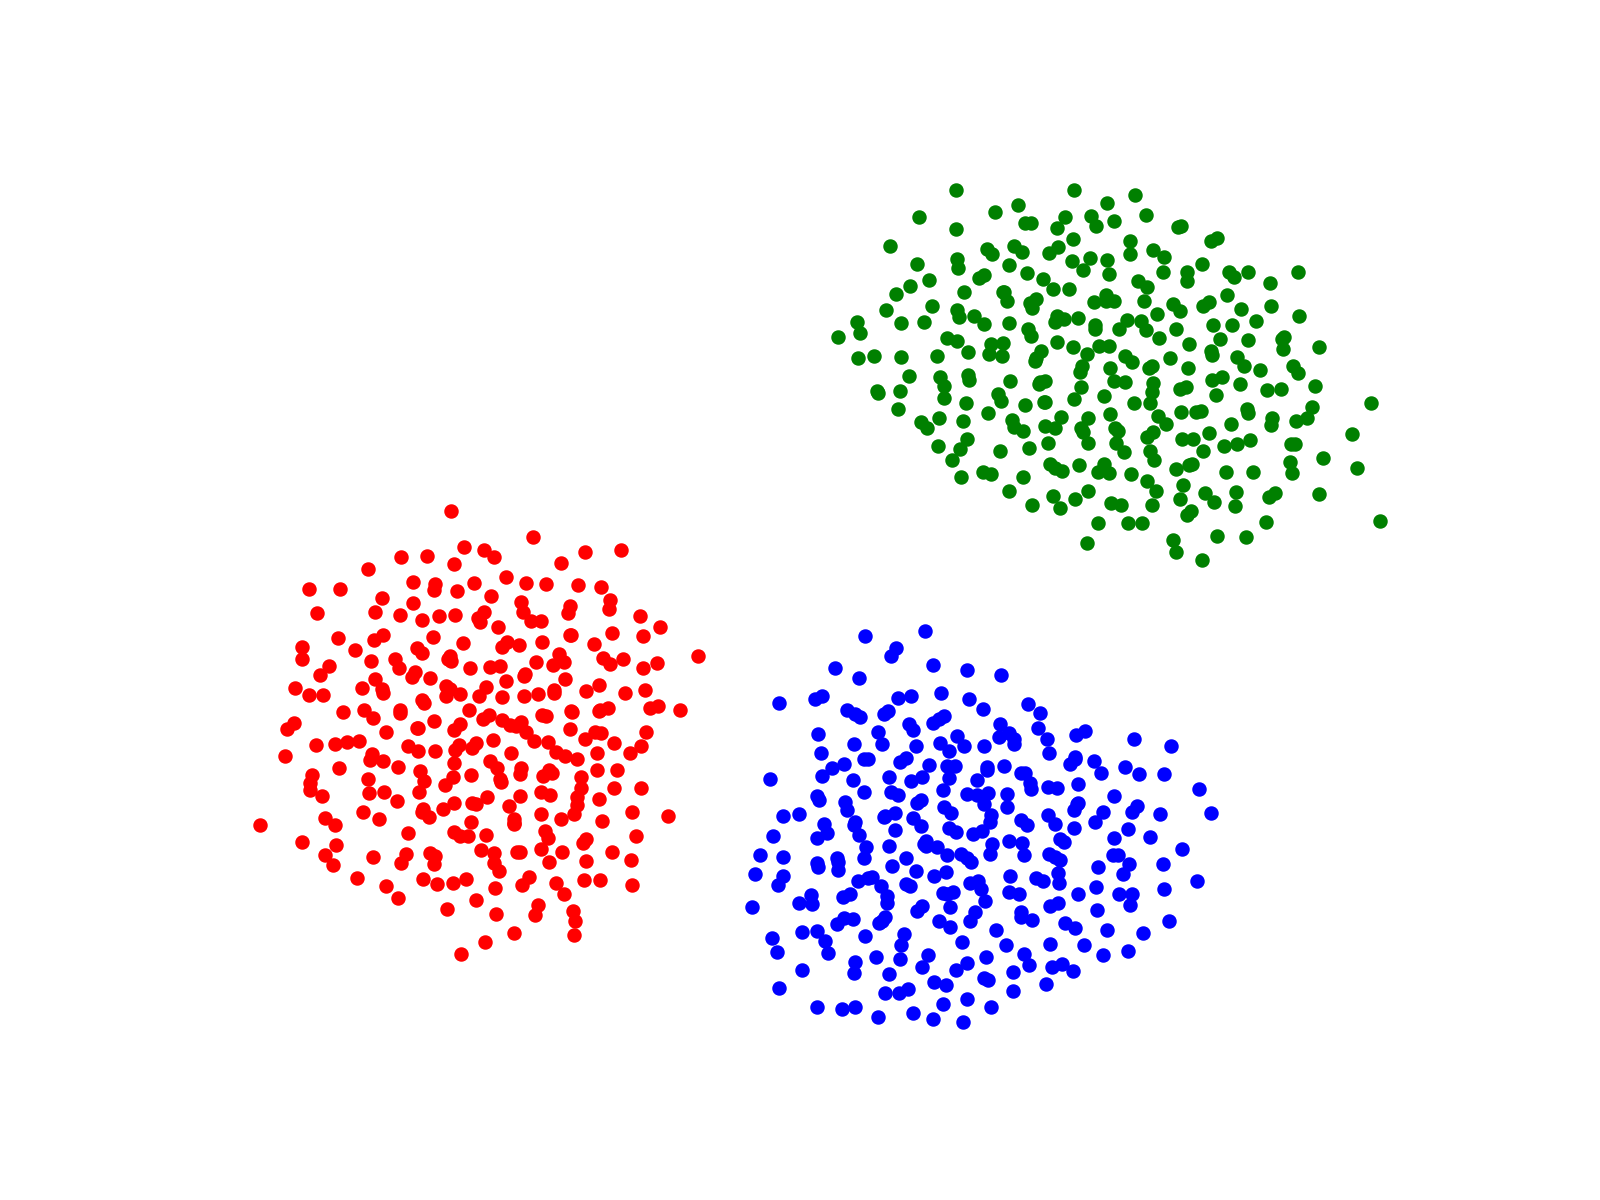

In [23]:
dmSpringGraph(BX, By, 100)

77401


<IPython.core.display.Javascript object>


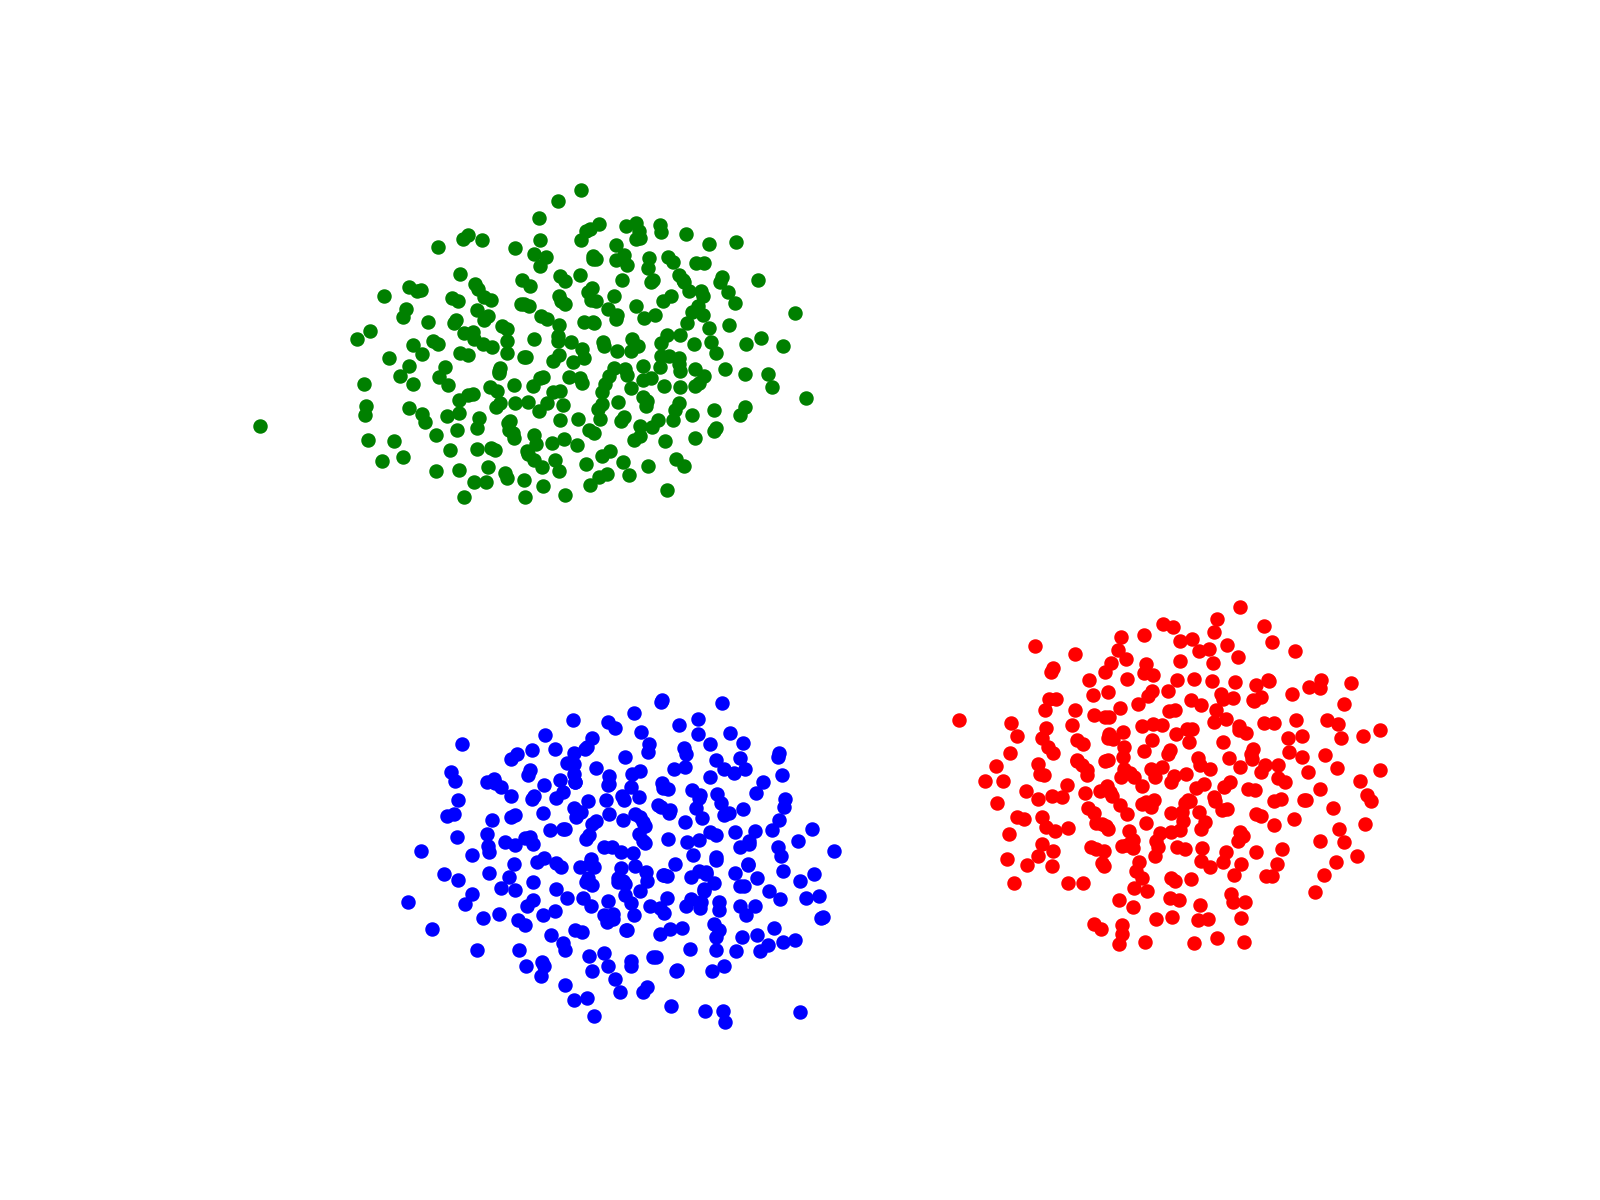

In [74]:
dmSpringKNNGraph(BX, By, iterations=100, k=50)

31018


<IPython.core.display.Javascript object>


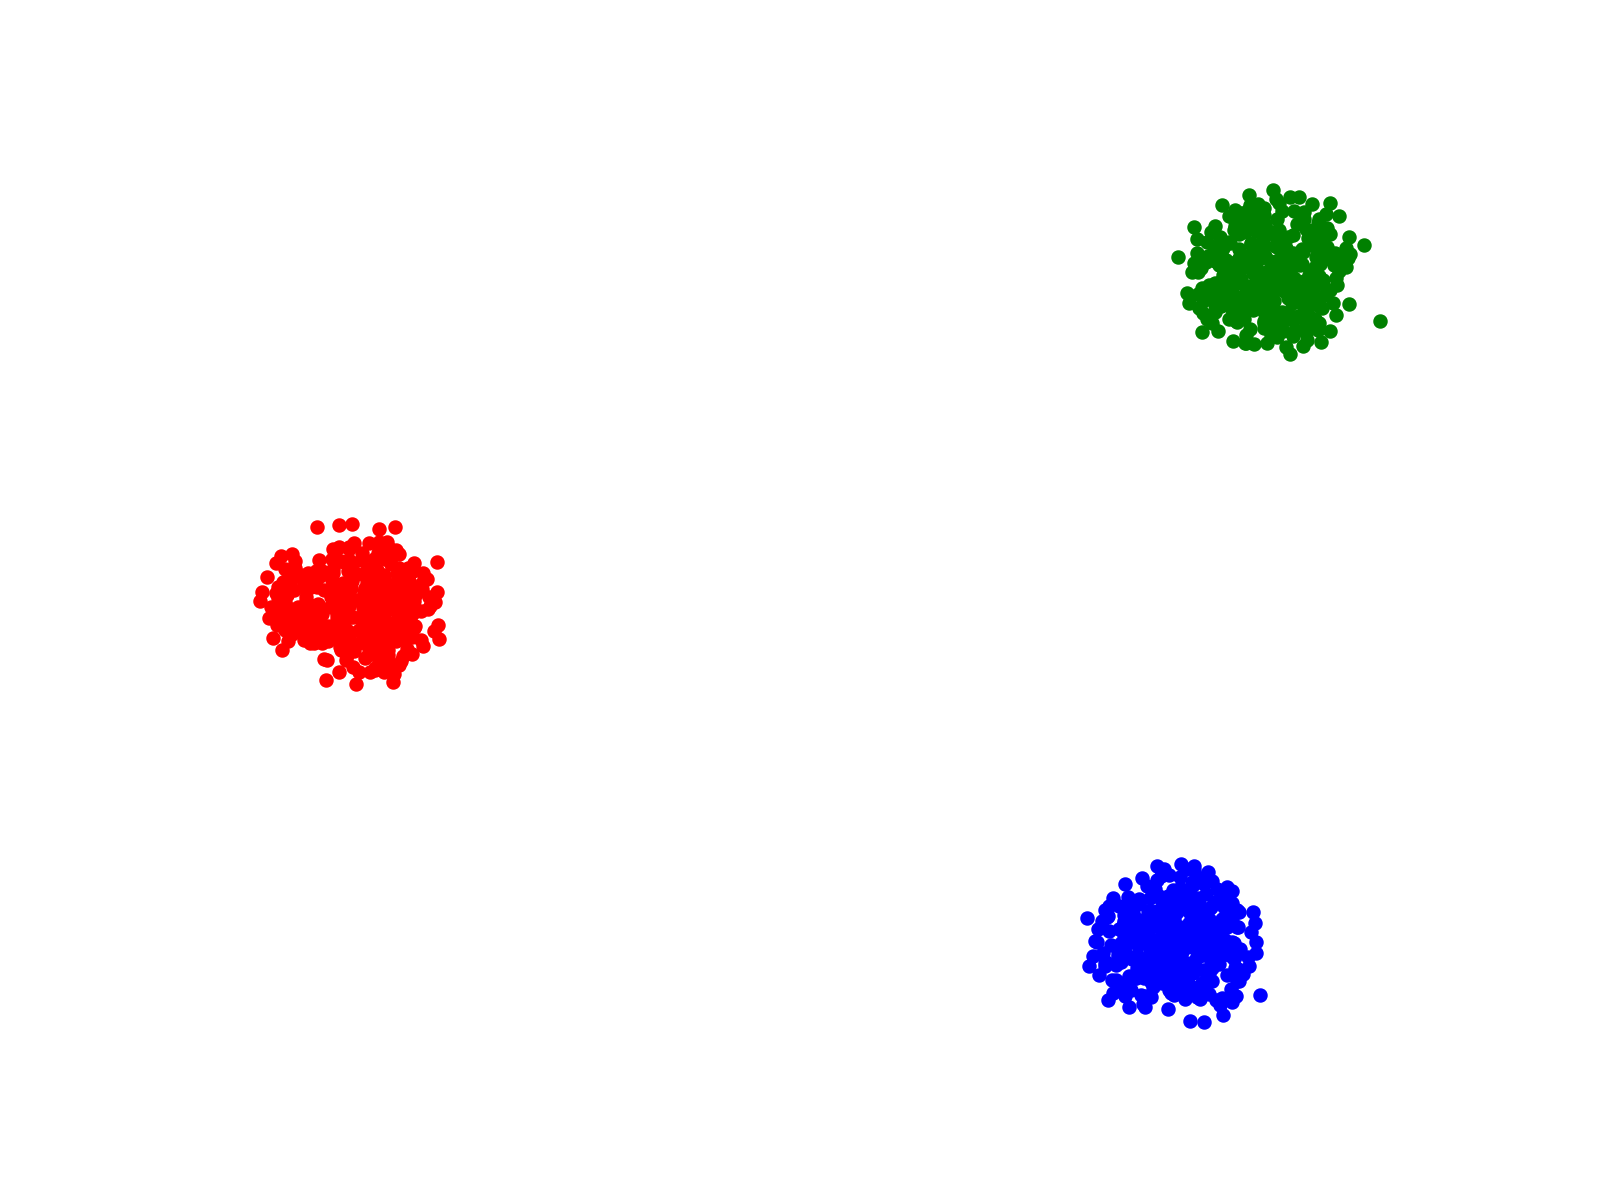

In [82]:
dmSpringKNNGraph(BX, By, iterations=100, k=50, farther=False)

In [34]:
graphJsonDump(dmSpringGraph(BX,By,plot=False,sample_edges=None), "viz-d3/graphs/BGraph.json")

In [25]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
MX = mnist.data / 255.0
My = mnist.target

In [26]:
rndperm = np.random.permutation(MX.shape[0])

In [28]:
from sklearn.decomposition import PCA
mnist_n = 5000
pca = PCA(n_components=100)
MX_sample = pca.fit_transform(MX[rndperm][:mnist_n])
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))

My_sample = My[rndperm][:mnist_n]
print(MX_sample.shape)
print(My_sample.shape)

Explained total variation: , 0.9159252674272065
(5000, 100)
(5000,)


In [29]:
dm_mnist = distanceMatrix(MX_sample, MX_sample)

In [30]:
G_mnist = genGraph(dm_mnist, My_sample)

In [31]:
pos_mnist = nx.spring_layout(G_mnist, dim=2, iterations=50)

<IPython.core.display.Javascript object>


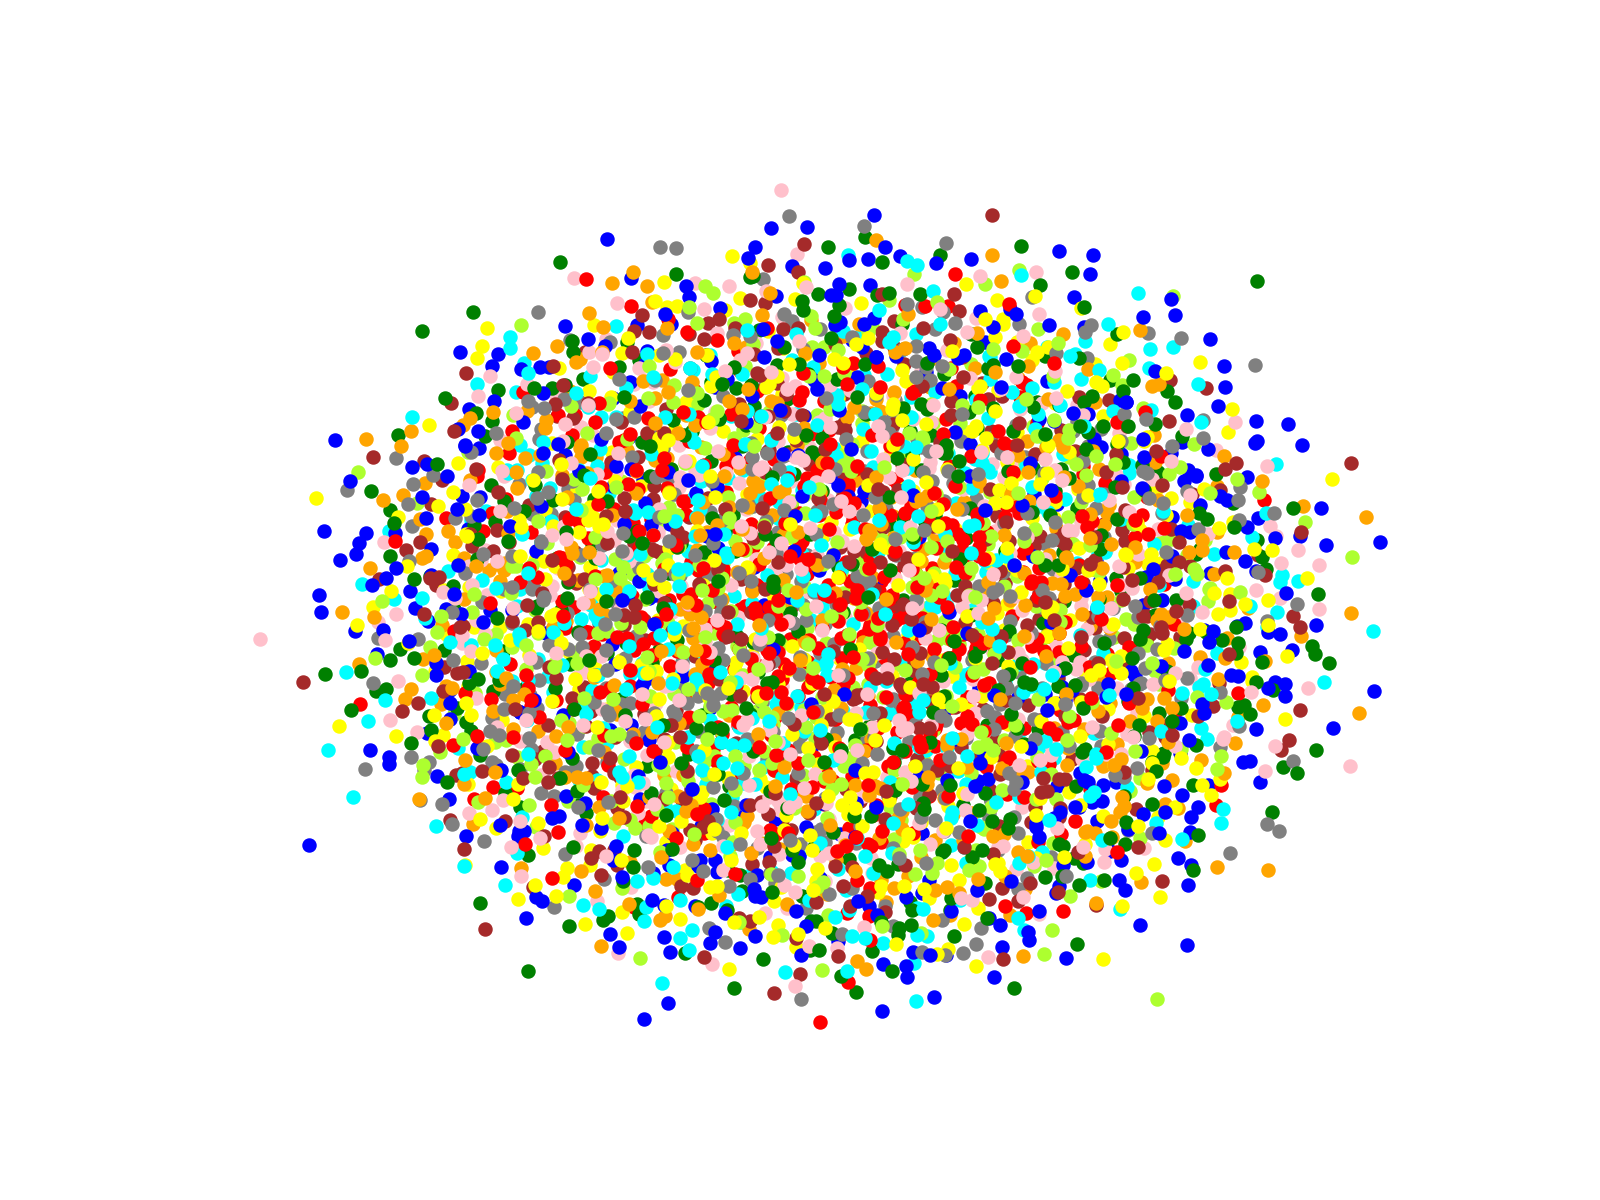

In [76]:
plotFDGraph(G_mnist, pos_mnist, My_sample)

425607


<IPython.core.display.Javascript object>


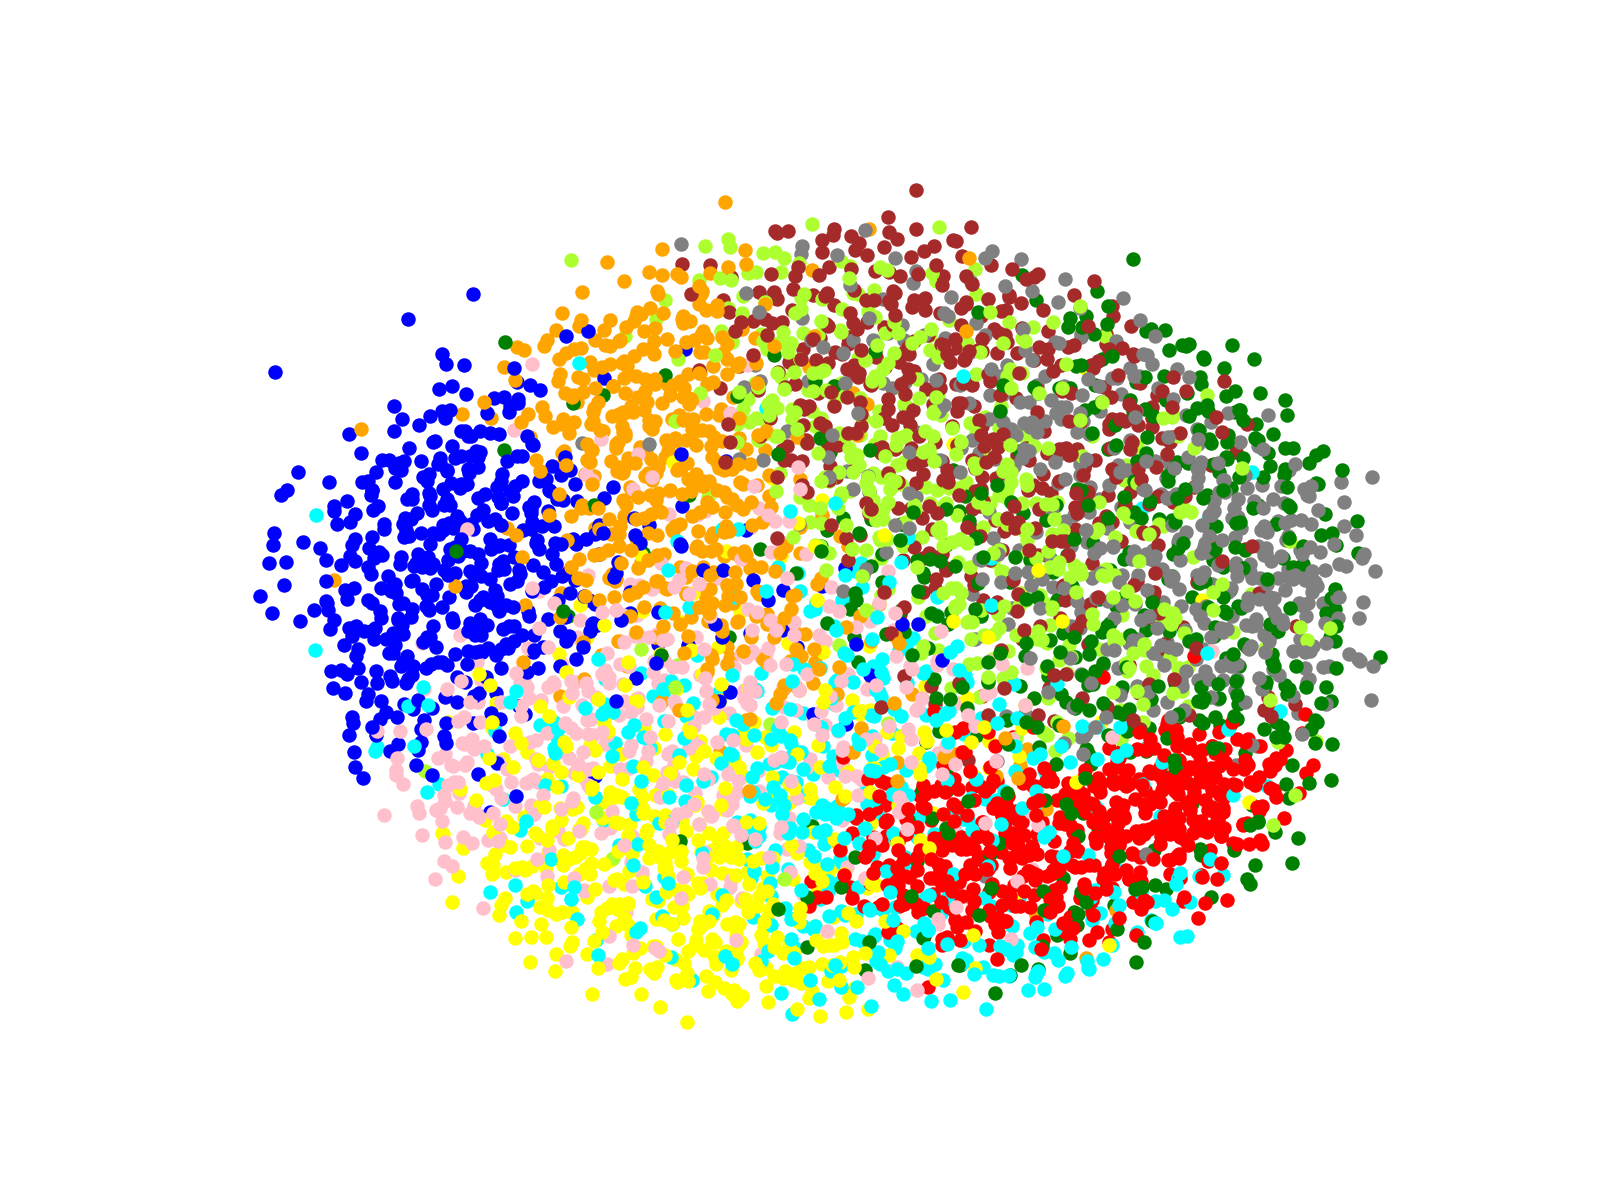

In [75]:
dmSpringKNNGraph(MX_sample, My_sample, iterations=100, k=50)

173750


<IPython.core.display.Javascript object>


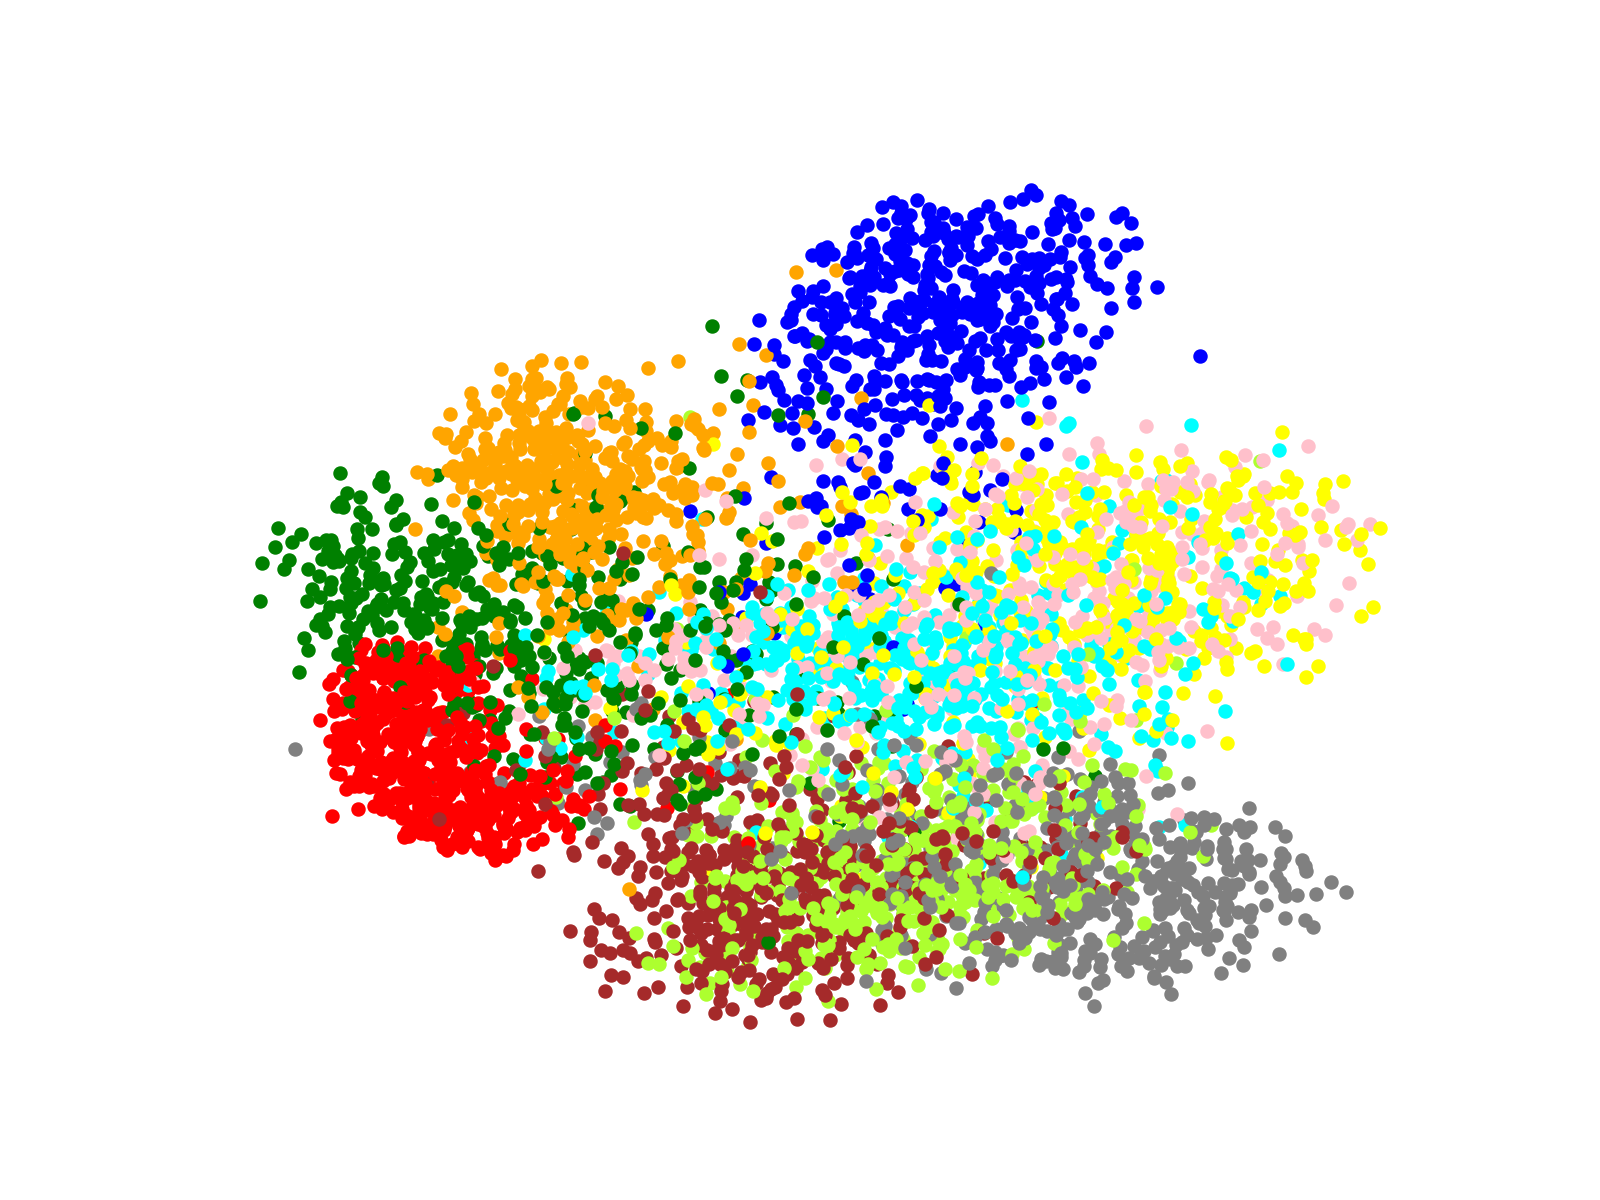

In [81]:
dmSpringKNNGraph(MX_sample, My_sample, iterations=100, k=50, farther=False)

18240


<IPython.core.display.Javascript object>


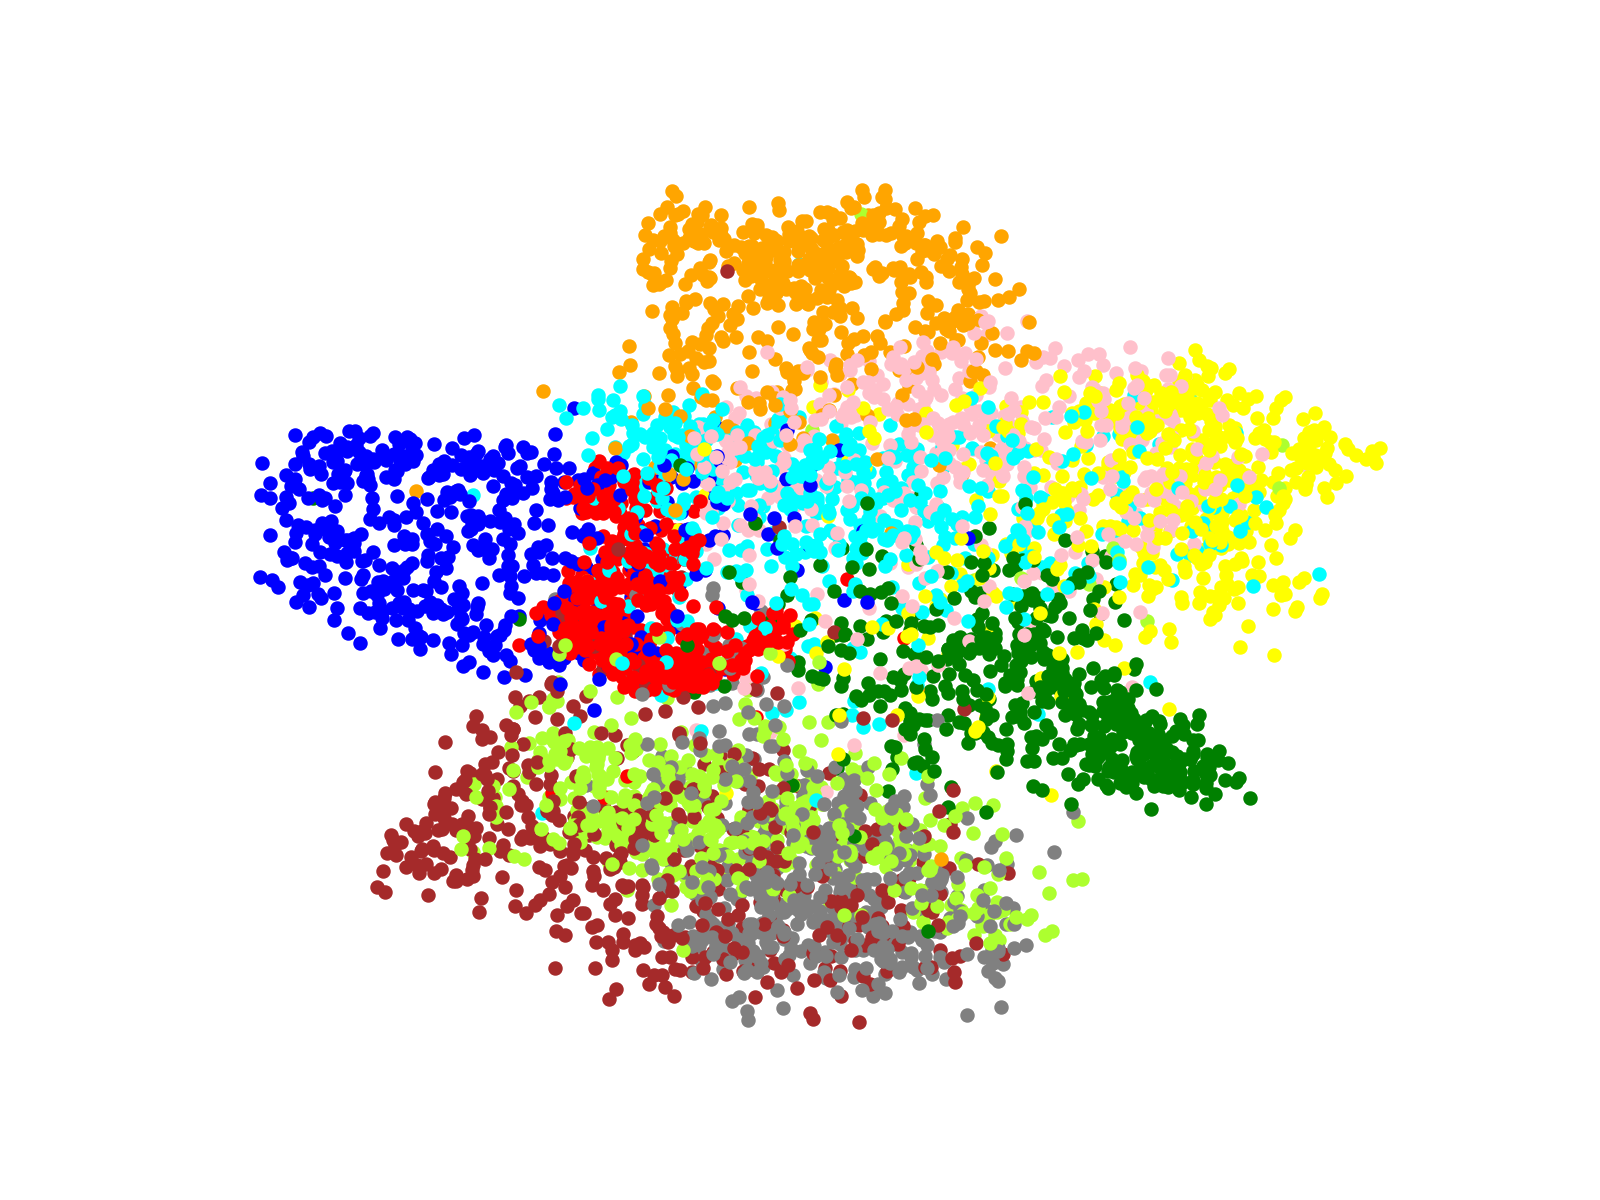

In [84]:
dmSpringKNNGraph(MX_sample, My_sample, iterations=100, k=5, farther=False)